In [1]:
import sys
sys.path.append('/Users/wastechs/Documents/git-repos/energy-efficiency')
from validation.gp.create_train_inference import create_train_inference_gp
from lib.util import helper, data_preprocessing
import torch
import gpytorch

In [2]:
group_2 = [
    'vk_2_eg', 'stahl_folder', 'r707lv_f4032', 
    'r707lv_f4034', 'r707lv_vari_air', 'r707lv_trockner', 'og_3'
]

### Kernel Composition

Trockner exhibits periodic patterns, and when these cycles occur, the power consumption has a large variation that fluctuates very quickly
 - This tells us that on top of a periodic kernel, their is short, but large varying fluctuations

In [3]:
## Locally Periodic Kernel ##

period_constraint_short = gpytorch.constraints.Interval(0.045, 0.055) ## short term

seasonal_periodic_short = gpytorch.kernels.ScaleKernel(
    gpytorch.kernels.PeriodicKernel(
        period_length_constraint=period_constraint_short
        )
    )

seasonal_rbf_short_lengthscale_prior = gpytorch.priors.GammaPrior(1, 0.5)
seasonal_rbf_short = gpytorch.kernels.ScaleKernel(
    gpytorch.kernels.RBFKernel(
        #lengthscale_prior=seasonal_rbf_short_lengthscale_prior
    )
)

#seasonal_rbf_short.base_kernel.lengthscale = seasonal_rbf_short_lengthscale_prior.mean

locally_short_periodic = seasonal_periodic_short * seasonal_rbf_short

period_constraint_long = gpytorch.constraints.Interval(0.065, 0.073) ## long term

seasonal_periodic_long = gpytorch.kernels.ScaleKernel(
    gpytorch.kernels.PeriodicKernel(
        period_length_constraint=period_constraint_long
        )
    )

seasonal_rbf_long = gpytorch.kernels.ScaleKernel(
    gpytorch.kernels.RBFKernel()
)

locally_long_periodic = seasonal_periodic_long * seasonal_rbf_long

## Local Variations ##
local_variation_alpha = gpytorch.priors.GammaPrior(1, 0.5)
#local_variation_lengthscale = gpytorch.priors.GammaPrior(1, 0.05)

local_variation = gpytorch.kernels.ScaleKernel(
    gpytorch.kernels.RQKernel()
    )
    
local_variation.alpha = local_variation_alpha.mean
#local_variation.lengthscale = local_variation_lengthscale

local_variation_2 = gpytorch.kernels.ScaleKernel(
    gpytorch.kernels.RBFKernel(
    )
)


#covar_module = locally_short_periodic + locally_long_periodic + local_variation # + local_variation_2
covar_module =  locally_long_periodic + local_variation + local_variation_2

In [4]:
## Locally Periodic Kernel ##

period_constraint_short = gpytorch.constraints.Interval(0.04, 0.055) ## short term

seasonal_periodic_short = gpytorch.kernels.ScaleKernel(
    gpytorch.kernels.PeriodicKernel(
        period_length_constraint=period_constraint_short
        )
    )

seasonal_rbf_short_lengthscale_prior = gpytorch.priors.GammaPrior(1, 0.5)
seasonal_rbf_short = gpytorch.kernels.ScaleKernel(
    gpytorch.kernels.RBFKernel(
        #lengthscale_prior=seasonal_rbf_short_lengthscale_prior
    )
)

locally_short_periodic = seasonal_periodic_short * seasonal_rbf_short

period_constraint_long = gpytorch.constraints.Interval(0.09, 0.12) ## long term

seasonal_periodic_long = gpytorch.kernels.ScaleKernel(
    gpytorch.kernels.PeriodicKernel(
        period_length_constraint=period_constraint_long
        )
    )

seasonal_rbf_long = gpytorch.kernels.ScaleKernel(
    gpytorch.kernels.RBFKernel(        
    )
)

locally_long_periodic = seasonal_periodic_long * seasonal_rbf_long

## Local Variations ##
local_variation_alpha = gpytorch.priors.GammaPrior(1, 0.5)
#local_variation_lengthscale = gpytorch.priors.GammaPrior(1, 0.05)

local_variation = gpytorch.kernels.ScaleKernel(
    gpytorch.kernels.RQKernel()
    )
    
#local_variation.alpha = local_variation_alpha.mean


covar_module =  locally_short_periodic + locally_long_periodic + local_variation
#covar_module = seasonal_periodic_long

In [5]:
X_train, y_train, X_test, y_test, n_train = data_preprocessing.gp_preprocess('r707lv_trockner_1H', 60, True)

Iter 1 , Loss = 1.5570707023711956 , Noise = 0.6932471990585327
Iter 2 , Loss = 1.5284317821634035 , Noise = 0.6444966793060303
Iter 3 , Loss = 1.5018411935471736 , Noise = 0.5982770919799805
Iter 4 , Loss = 1.477560890265276 , Noise = 0.5546213984489441
Iter 5 , Loss = 1.455812880064981 , Noise = 0.5135741829872131
Iter 6 , Loss = 1.4367505933467803 , Noise = 0.4751947820186615
Iter 7 , Loss = 1.4204251146372393 , Noise = 0.43956032395362854
Iter 8 , Loss = 1.4067464444479842 , Noise = 0.4067663550376892
Iter 9 , Loss = 1.3954393631296527 , Noise = 0.3769214451313019
Iter 10 , Loss = 1.3859958334317972 , Noise = 0.3501313626766205
Iter 11 , Loss = 1.377643937406085 , Noise = 0.3264678418636322
Iter 12 , Loss = 1.3693953506111949 , Noise = 0.3059218227863312
Iter 13 , Loss = 1.3602523548979202 , Noise = 0.2883547246456146
Iter 14 , Loss = 1.349535088122529 , Noise = 0.2734758257865906
Iter 15 , Loss = 1.337104767871388 , Noise = 0.26086440682411194
Iter 16 , Loss = 1.323316885523903 , 

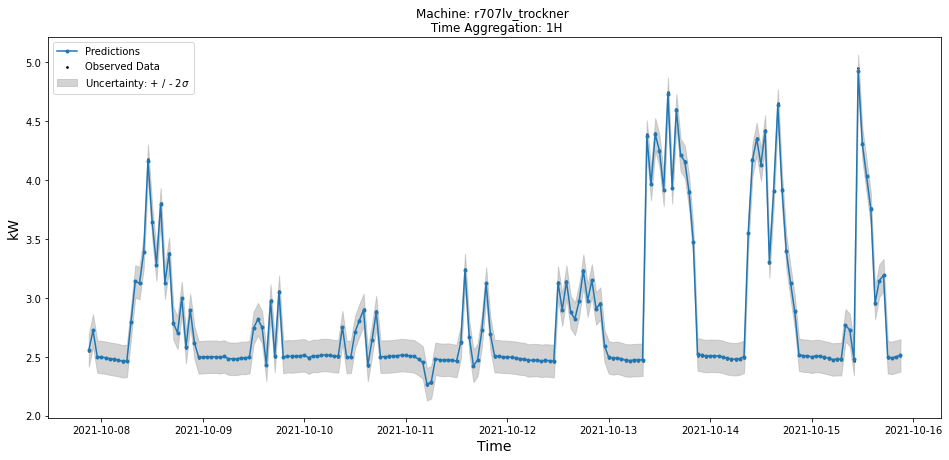

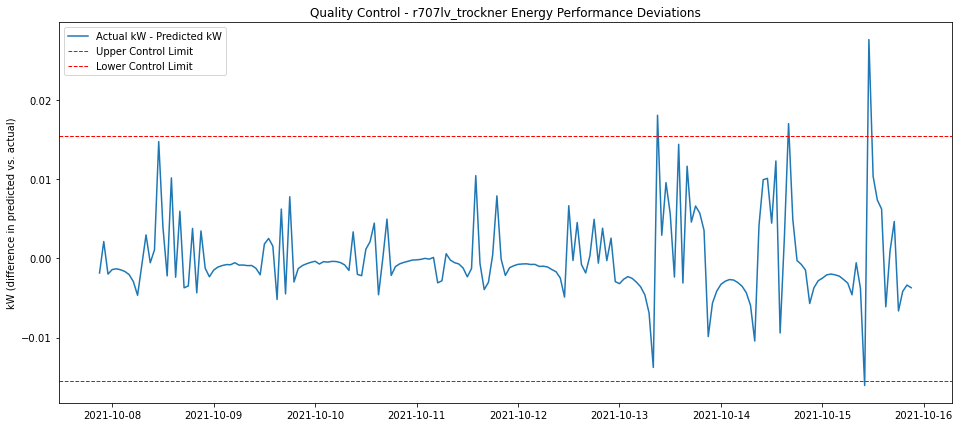

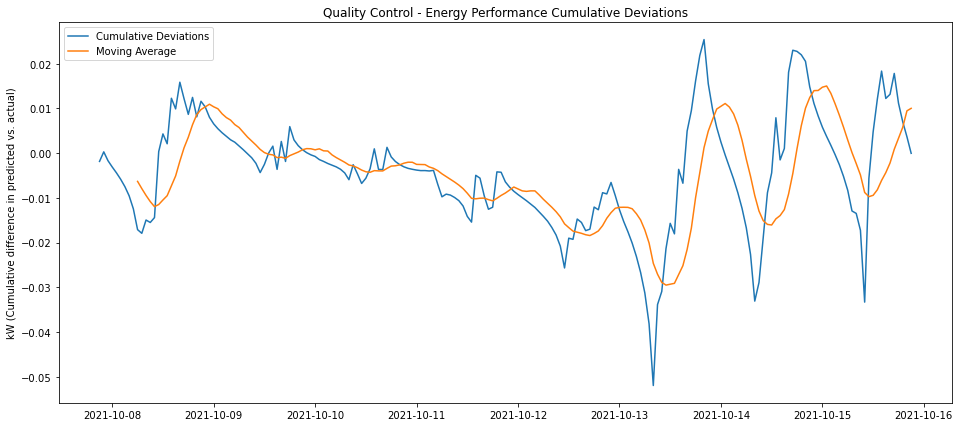

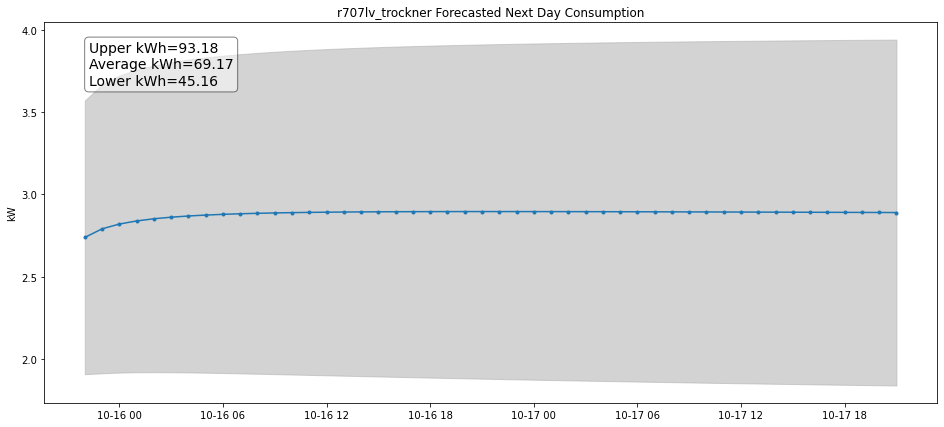

In [6]:
func_preds_mean_inv, func_preds_var_inv, observed_preds, mse, mape = create_train_inference_gp(
    kernel_gen=covar_module,
    train_x=X_train,
    train_y=y_train,
    test_x=X_test,
    test_y=y_test,
    n_train=n_train,
    training_iter=100,
    lr=0.1,
    time_agg='1H',
    machine='r707lv_trockner',
    update_score=False
)   

In [15]:
mse, mape

NameError: name 'mse' is not defined

### 10T

In [9]:
## Locally Periodic Kernel ##
period_constraint_short = gpytorch.constraints.Interval(0.083, 0.126) ## short term

seasonal_periodic_short = gpytorch.kernels.ScaleKernel(
    gpytorch.kernels.PeriodicKernel(
        period_length_constraint=period_constraint_short
        )
    )

seasonal_rbf_short = gpytorch.kernels.ScaleKernel(
    gpytorch.kernels.RBFKernel()
)

locally_short_periodic = seasonal_periodic_short * seasonal_rbf_short

period_constraint_long = gpytorch.constraints.Interval(0.167, 0.209) ## long term

seasonal_periodic_long = gpytorch.kernels.ScaleKernel(
    gpytorch.kernels.PeriodicKernel(
        period_length_constraint=period_constraint_long
        )
    )

seasonal_rbf_long = gpytorch.kernels.ScaleKernel(
    gpytorch.kernels.RBFKernel()
)

locally_long_periodic = seasonal_periodic_long * seasonal_rbf_long

## Local Variations ##
local_variation_alpha = gpytorch.priors.GammaPrior(1, 0.5)

local_variation = gpytorch.kernels.ScaleKernel(
    gpytorch.kernels.RQKernel()
    )
    
local_variation.alpha = local_variation_alpha


covar_module = locally_short_periodic + locally_long_periodic + local_variation


In [10]:
X_train, y_train, X_test, y_test, n_train = data_preprocessing.gp_preprocess('vk_2_eg_30T', 30, True)

Iter 1 , Loss = 1.1167325933146015 , Noise = 0.6932471990585327
Iter 2 , Loss = 1.0860422000868042 , Noise = 0.6444966793060303
Iter 3 , Loss = 1.0578813669127018 , Noise = 0.5982540845870972
Iter 4 , Loss = 1.034519570589345 , Noise = 0.5545238852500916
Iter 5 , Loss = 1.016989282242349 , Noise = 0.5133202075958252
Iter 6 , Loss = 1.0029779132467664 , Noise = 0.4746778905391693
Iter 7 , Loss = 0.9891673703587464 , Noise = 0.4386254549026489
Iter 8 , Loss = 0.974480447016517 , Noise = 0.4051511883735657
Iter 9 , Loss = 0.9593008503451905 , Noise = 0.37420448660850525
Iter 10 , Loss = 0.9444954295627985 , Noise = 0.3457084596157074
Iter 11 , Loss = 0.9311038585661806 , Noise = 0.3195689618587494
Iter 12 , Loss = 0.9202051139326329 , Noise = 0.29568687081336975
Iter 13 , Loss = 0.9120358580878859 , Noise = 0.27397993206977844
Iter 14 , Loss = 0.9053210593234681 , Noise = 0.25439631938934326
Iter 15 , Loss = 0.8990413582122293 , Noise = 0.2368994802236557
Iter 16 , Loss = 0.89371013735091

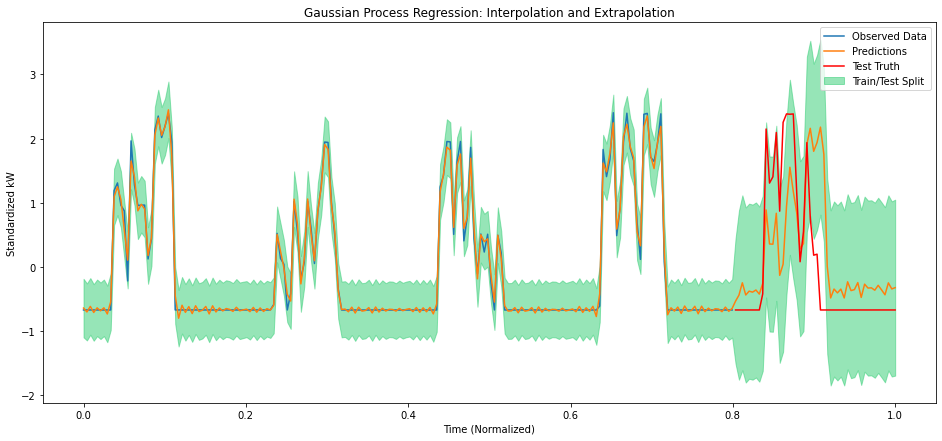

Points outside of confidence region: [2.25321257 2.38491068]


In [11]:
model, likelihood, mse, mape = create_train_inference_gp(
    kernel_gen=covar_module,
    train_x=X_train,
    train_y=y_train,
    test_x=X_test,
    test_y=y_test,
    n_train=n_train,
    time_agg='30T',
    machine='vk_2_eg',
    update_score=False
)   

In [12]:
mse, mape

(0.8419735761654904, 1.0628913651431569)